1. Importación de Librerías y Carga del Modelo

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Cargar el modelo de Red Bayesiana
print("Cargando modelo de Red Bayesiana...")
with open('output/modelos/red_bayesiana_diabetes.pkl', 'rb') as f:
    bayesian_model = pickle.load(f)

# Cargar datos
df = pd.read_csv('data/processed/diabetes_processed.csv')
print(f"Dataset cargado: {df.shape[0]:,} registros")

# División de datos
X = df.drop('Complicacion', axis=1)
y = df['Complicacion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {len(X_train):,} registros")
print(f"Conjunto de prueba: {len(X_test):,} registros")

Cargando modelo de Red Bayesiana...
Dataset cargado: 86,936 registros
Conjunto de entrenamiento: 69,548 registros
Conjunto de prueba: 17,388 registros


In [52]:
# 1. Seleccionar variables sanas (igual que en Notebook 03)
variables_validas = [
    'Edad_cat',
    'Sexo',
    'Tipo_DM',
    'Departamento',
    'Servicio_Hospitalario',
    'Mes_Muestra',
    # Agrega aquí otras variables válidas que usaste en el notebook 03
    # No uses resultados de laboratorio, IDs, fechas ni ningún campo leakage
]

X = df[variables_validas].copy()
y = df['Complicacion']

# 2. Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {len(X_train):,} registros")
print(f"Conjunto de prueba: {len(X_test):,} registros")

# 3. Encoding robusto para variables categóricas (LabelEncoder)
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
label_encoders = {}

for column in X_train.columns:
    le = LabelEncoder()
    X_train_encoded[column] = le.fit_transform(X_train[column].astype(str))
    # Map test set categories; unseen labels serán -1
    mapping = {label: idx for idx, label in enumerate(le.classes_)}
    X_test_encoded[column] = X_test[column].astype(str).map(lambda s: mapping.get(s, -1))
    label_encoders[column] = le


Conjunto de entrenamiento: 69,548 registros
Conjunto de prueba: 17,388 registros


2. Funciones de Utilidad para Inferencia

In [53]:
def predict_proba_bayesian(model, X, show_progress=True):
    """
    Predice probabilidades usando la red bayesiana
    """
    inference = VariableElimination(model)
    probabilities = []
    
    for idx, row in X.iterrows():
        evidence = row.to_dict()
        
        try:
            posterior = inference.query(variables=['Complicacion'], evidence=evidence)
            prob_complicacion = posterior.values[1]
            probabilities.append(prob_complicacion)
        except:
            probabilities.append(0.5)  # Probabilidad neutral si hay error
        
        if show_progress and (idx + 1) % 500 == 0:
            print(f"Procesados {idx + 1}/{len(X)} registros...")
    
    return np.array(probabilities)

def stratified_risk_classification(probability):
    """
    Clasifica el riesgo en categorías
    """
    if probability < 0.2:
        return 'Muy Bajo'
    elif probability < 0.4:
        return 'Bajo'
    elif probability < 0.6:
        return 'Moderado'
    elif probability < 0.8:
        return 'Alto'
    else:
        return 'Muy Alto'

def get_patient_recommendations(evidence, probability, model):
    """
    Genera recomendaciones personalizadas basadas en el perfil del paciente
    """
    recommendations = []
    risk_level = stratified_risk_classification(probability)
    
    # Recomendaciones basadas en nivel de riesgo
    if risk_level in ['Alto', 'Muy Alto']:
        recommendations.append("⚠️ ATENCIÓN PRIORITARIA: Requiere evaluación médica inmediata")
        
        if evidence.get('Glucosa_cat') == 'Diabetes_Descontrolada':
            recommendations.append("🔴 Control glucémico urgente - Ajustar medicación")
        
        if evidence.get('Edad_cat') in ['Adulto_Mayor', 'Anciano']:
            recommendations.append("👴 Implementar protocolo geriátrico especializado")
            
        if evidence.get('Colesterol_cat') == 'Alto':
            recommendations.append("💊 Evaluar terapia con estatinas")
            
    elif risk_level == 'Moderado':
        recommendations.append("⚡ Seguimiento cercano recomendado (cada 3 meses)")
        recommendations.append("📊 Monitoreo continuo de glucosa")
        recommendations.append("🏃 Programa de ejercicio supervisado")
        
    else:  # Bajo o Muy Bajo
        recommendations.append("✅ Mantener controles regulares (cada 6 meses)")
        recommendations.append("🥗 Continuar con estilo de vida saludable")
        recommendations.append("📱 Considerar uso de app de monitoreo")
    
    # Recomendaciones específicas por departamento
    if evidence.get('Departamento') == 'PUNO':
        recommendations.append("🏔️ Considerar factores de altitud en el tratamiento")
    
    return recommendations, risk_level




3. Comparación con Modelos Tradicionales

In [54]:
# Preparar datos para modelos tradicionales (encoding)
print("Preparando datos para modelos tradicionales...")

# Crear copias para encoding
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Label encoding para variables categóricas
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
label_encoders = {}

for column in X_train.columns:
    le = LabelEncoder()
    X_train_encoded[column] = le.fit_transform(X_train[column].astype(str))
    
    # Manejar etiquetas desconocidas en test como -1
    mapping = {label: idx for idx, label in enumerate(le.classes_)}
    X_test_encoded[column] = X_test[column].astype(str).map(lambda x: mapping.get(x, -1))
    
    label_encoders[column] = le


# Entrenar modelos tradicionales
print("\nEntrenando modelos de comparación...")

# 1. Regresión Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_encoded, y_train)

# 2. Árbol de Decisión
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
decision_tree.fit(X_train_encoded, y_train)

# 3. Random Forest
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest.fit(X_train_encoded, y_train)

print("Modelos entrenados correctamente")

Preparando datos para modelos tradicionales...

Entrenando modelos de comparación...
Modelos entrenados correctamente


4. Evaluación Comparativa de Modelos


Evaluando Red Bayesiana (muestra de 1000 registros)...

Evaluando Regresión Logística...

Evaluando Árbol de Decisión...

Evaluando Random Forest...

COMPARACIÓN DE MODELOS
             Modelo  Accuracy  AUC-ROC
      Red Bayesiana  0.817000 0.787885
Regresión Logística  0.778180 0.682303
  Árbol de Decisión  0.825569 0.823555
      Random Forest  0.842305 0.850878


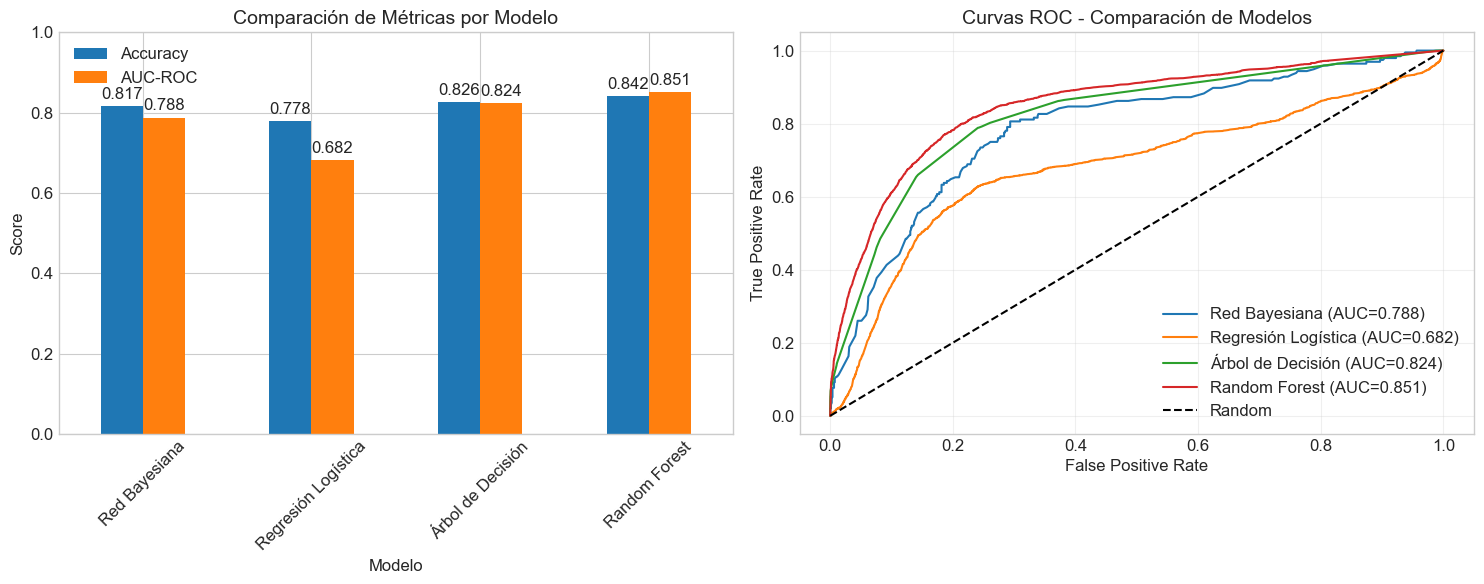

In [55]:
# Función para evaluar modelos
def evaluate_model(model, X_test, y_test, model_name, is_bayesian=False):
    """
    Evalúa un modelo y retorna métricas
    """
    if is_bayesian:
        # Usar muestra para red bayesiana (por eficiencia)
        sample_size = min(1000, len(X_test))
        X_sample = X_test.sample(n=sample_size, random_state=42)
        y_sample = y_test[X_sample.index]
        
        print(f"\nEvaluando {model_name} (muestra de {sample_size} registros)...")
        y_proba = predict_proba_bayesian(model, X_sample, show_progress=False)
        y_pred = (y_proba > 0.5).astype(int)
        
        return {
            'model': model_name,
            'accuracy': accuracy_score(y_sample, y_pred),
            'auc_roc': roc_auc_score(y_sample, y_proba),
            'y_true': y_sample,
            'y_pred': y_pred,
            'y_proba': y_proba
        }
    else:
        print(f"\nEvaluando {model_name}...")
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        return {
            'model': model_name,
            'accuracy': accuracy_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_proba),
            'y_true': y_test,
            'y_pred': y_pred,
            'y_proba': y_proba
        }

# Evaluar todos los modelos
results = []

# Red Bayesiana
results.append(evaluate_model(bayesian_model, X_test, y_test, 'Red Bayesiana', is_bayesian=True))

# Modelos tradicionales
results.append(evaluate_model(log_reg, X_test_encoded, y_test, 'Regresión Logística'))
results.append(evaluate_model(decision_tree, X_test_encoded, y_test, 'Árbol de Decisión'))
results.append(evaluate_model(random_forest, X_test_encoded, y_test, 'Random Forest'))

# Crear DataFrame con resultados
results_df = pd.DataFrame([{
    'Modelo': r['model'],
    'Accuracy': r['accuracy'],
    'AUC-ROC': r['auc_roc']
} for r in results])

print("\n" + "="*50)
print("COMPARACIÓN DE MODELOS")
print("="*50)
print(results_df.to_string(index=False))

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para métricas
results_df.set_index('Modelo')[['Accuracy', 'AUC-ROC']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparación de Métricas por Modelo', fontsize=14)
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(['Accuracy', 'AUC-ROC'])
axes[0].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3)

# Curvas ROC
for result in results:
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
    axes[1].plot(fpr, tpr, label=f"{result['model']} (AUC={result['auc_roc']:.3f})")

axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Curvas ROC - Comparación de Modelos', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/resultados/comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

5. Análisis Detallado para el Departamento de PUNO

Análisis específico para PUNO
Total de pacientes en Puno: 1,981
Tasa de complicaciones en Puno: 55.48%
Tasa nacional: 21.32%

Calculando predicciones para muestra de Puno...


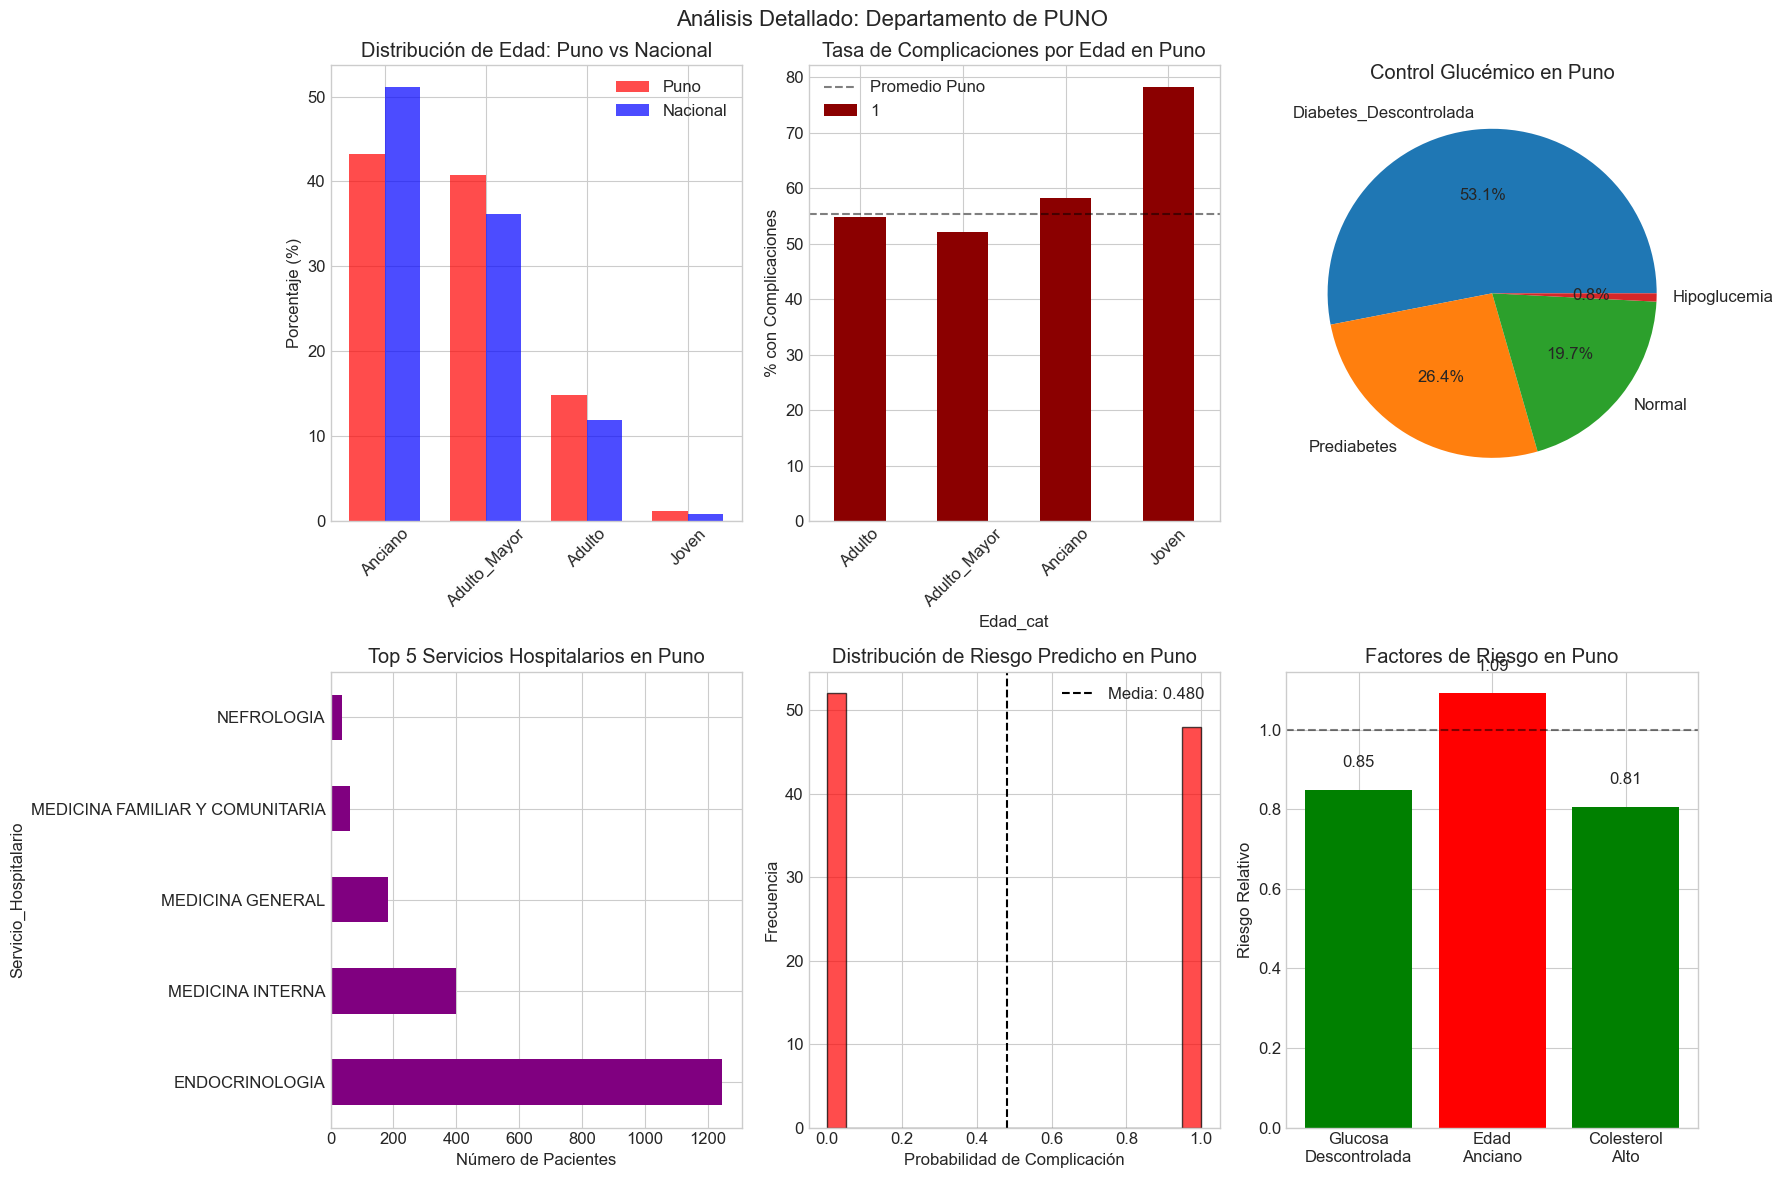


RESUMEN EJECUTIVO - DEPARTAMENTO DE PUNO

    1. SITUACIÓN ACTUAL:
       - Pacientes diabéticos: 1,981
       - Tasa de complicaciones: 55.48%
       - Diferencia vs nacional: +34.16 puntos porcentuales

    2. PERFIL PREDOMINANTE:
       - Edad más común: Anciano
       - Tipo de diabetes más común: Tipo_2
       - Servicio más utilizado: ENDOCRINOLOGIA

    3. FACTORES DE RIESGO CRÍTICOS:
       - Pacientes con glucosa descontrolada: 53.1%
       - Pacientes ancianos: 43.3%
       - Pacientes con colesterol alto: 10.5%
    


In [56]:
# Filtrar datos de Puno
df_puno = df[df['Departamento'] == 'PUNO'].copy()
X_puno = df_puno.drop('Complicacion', axis=1)
y_puno = df_puno['Complicacion']

print(f"Análisis específico para PUNO")
print(f"Total de pacientes en Puno: {len(df_puno):,}")
print(f"Tasa de complicaciones en Puno: {y_puno.mean()*100:.2f}%")
print(f"Tasa nacional: {y.mean()*100:.2f}%")

if len(df_puno) > 0:
    # Análisis de factores de riesgo en Puno
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Distribución de edad en Puno vs Nacional
    ax1 = axes[0, 0]
    edad_puno = df_puno['Edad_cat'].value_counts(normalize=True) * 100
    edad_nacional = df['Edad_cat'].value_counts(normalize=True) * 100
    
    x = np.arange(len(edad_puno))
    width = 0.35
    
    ax1.bar(x - width/2, edad_puno.values, width, label='Puno', color='red', alpha=0.7)
    ax1.bar(x + width/2, edad_nacional.reindex(edad_puno.index).values, width, 
            label='Nacional', color='blue', alpha=0.7)
    ax1.set_xticks(x)
    ax1.set_xticklabels(edad_puno.index, rotation=45)
    ax1.set_ylabel('Porcentaje (%)')
    ax1.set_title('Distribución de Edad: Puno vs Nacional')
    ax1.legend()
    
    # 2. Complicaciones por edad en Puno
    ax2 = axes[0, 1]
    comp_edad_puno = pd.crosstab(df_puno['Edad_cat'], df_puno['Complicacion'], normalize='index') * 100
    if 1 in comp_edad_puno.columns:
        comp_edad_puno[1].plot(kind='bar', ax=ax2, color='darkred')
        ax2.set_title('Tasa de Complicaciones por Edad en Puno')
        ax2.set_ylabel('% con Complicaciones')
        ax2.tick_params(axis='x', rotation=45)
        ax2.axhline(y=y_puno.mean()*100, color='black', linestyle='--', alpha=0.5, label='Promedio Puno')
        ax2.legend()
    
    # 3. Control glucémico en Puno
    ax3 = axes[0, 2]
    glucosa_puno = df_puno['Glucosa_cat'].value_counts(normalize=True) * 100
    glucosa_puno.plot(kind='pie', ax=ax3, autopct='%1.1f%%')
    ax3.set_title('Control Glucémico en Puno')
    ax3.set_ylabel('')
    
    # 4. Servicios más utilizados en Puno
    ax4 = axes[1, 0]
    servicios_puno = df_puno['Servicio_Hospitalario'].value_counts().head(5)
    servicios_puno.plot(kind='barh', ax=ax4, color='purple')
    ax4.set_title('Top 5 Servicios Hospitalarios en Puno')
    ax4.set_xlabel('Número de Pacientes')
    
    # 5. Predicciones para pacientes de Puno
    ax5 = axes[1, 1]
    if len(X_puno) > 50:
        # Tomar muestra para predicción
        sample_puno = X_puno.sample(n=min(100, len(X_puno)), random_state=42)
        y_sample_puno = y_puno[sample_puno.index]
        
        # Predecir con red bayesiana
        print("\nCalculando predicciones para muestra de Puno...")
        proba_puno = predict_proba_bayesian(bayesian_model, sample_puno, show_progress=False)
        
        # Distribución de probabilidades
        ax5.hist(proba_puno, bins=20, alpha=0.7, color='red', edgecolor='black')
        ax5.axvline(x=proba_puno.mean(), color='black', linestyle='--', 
                   label=f'Media: {proba_puno.mean():.3f}')
        ax5.set_xlabel('Probabilidad de Complicación')
        ax5.set_ylabel('Frecuencia')
        ax5.set_title('Distribución de Riesgo Predicho en Puno')
        ax5.legend()
    
    # 6. Factores de riesgo específicos de Puno
    ax6 = axes[1, 2]
    # Calcular odds ratios simplificados
    factores_riesgo_puno = []
    
    # Glucosa descontrolada
    if 'Diabetes_Descontrolada' in df_puno['Glucosa_cat'].values:
        riesgo_glucosa = df_puno[df_puno['Glucosa_cat'] == 'Diabetes_Descontrolada']['Complicacion'].mean()
        riesgo_base = df_puno[df_puno['Glucosa_cat'] != 'Diabetes_Descontrolada']['Complicacion'].mean()
        if riesgo_base > 0:
            factores_riesgo_puno.append(('Glucosa\nDescontrolada', riesgo_glucosa / riesgo_base))
    
    # Ancianos
    if 'Anciano' in df_puno['Edad_cat'].values:
        riesgo_anciano = df_puno[df_puno['Edad_cat'] == 'Anciano']['Complicacion'].mean()
        riesgo_no_anciano = df_puno[df_puno['Edad_cat'] != 'Anciano']['Complicacion'].mean()
        if riesgo_no_anciano > 0:
            factores_riesgo_puno.append(('Edad\nAnciano', riesgo_anciano / riesgo_no_anciano))
    
    # Colesterol alto
    if 'Alto' in df_puno['Colesterol_cat'].values:
        riesgo_colesterol = df_puno[df_puno['Colesterol_cat'] == 'Alto']['Complicacion'].mean()
        riesgo_no_colesterol = df_puno[df_puno['Colesterol_cat'] != 'Alto']['Complicacion'].mean()
        if riesgo_no_colesterol > 0:
            factores_riesgo_puno.append(('Colesterol\nAlto', riesgo_colesterol / riesgo_no_colesterol))
    
    if factores_riesgo_puno:
        factores, ratios = zip(*factores_riesgo_puno)
        bars = ax6.bar(range(len(factores)), ratios, color=['red' if r > 1 else 'green' for r in ratios])
        ax6.set_xticks(range(len(factores)))
        ax6.set_xticklabels(factores)
        ax6.axhline(y=1, color='black', linestyle='--', alpha=0.5)
        ax6.set_ylabel('Riesgo Relativo')
        ax6.set_title('Factores de Riesgo en Puno')
        
        # Agregar valores
        for bar, ratio in zip(bars, ratios):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{ratio:.2f}', ha='center', va='bottom')
    
    plt.suptitle('Análisis Detallado: Departamento de PUNO', fontsize=16)
    plt.tight_layout()
    plt.savefig('output/resultados/analisis_puno_detallado.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Resumen ejecutivo para Puno
    print("\n" + "="*60)
    print("RESUMEN EJECUTIVO - DEPARTAMENTO DE PUNO")
    print("="*60)
    print(f"""
    1. SITUACIÓN ACTUAL:
       - Pacientes diabéticos: {len(df_puno):,}
       - Tasa de complicaciones: {y_puno.mean()*100:.2f}%
       - Diferencia vs nacional: {(y_puno.mean() - y.mean())*100:+.2f} puntos porcentuales
    
    2. PERFIL PREDOMINANTE:
       - Edad más común: {df_puno['Edad_cat'].mode()[0]}
       - Tipo de diabetes más común: {df_puno['Tipo_DM'].mode()[0]}
       - Servicio más utilizado: {df_puno['Servicio_Hospitalario'].mode()[0]}
    
    3. FACTORES DE RIESGO CRÍTICOS:
       - Pacientes con glucosa descontrolada: {(df_puno['Glucosa_cat'] == 'Diabetes_Descontrolada').mean()*100:.1f}%
       - Pacientes ancianos: {(df_puno['Edad_cat'] == 'Anciano').mean()*100:.1f}%
       - Pacientes con colesterol alto: {(df_puno['Colesterol_cat'] == 'Alto').mean()*100:.1f}%
    """)

6. Sistema de Inferencia Interactivo

In [57]:
def sistema_inferencia_interactivo(model, label_encoders=None):
    """
    Sistema interactivo para realizar inferencias personalizadas
    """
    inference = VariableElimination(model)
    
    print("\n" + "="*60)
    print("SISTEMA DE INFERENCIA INTERACTIVO")
    print("="*60)
    print("Ingrese los datos del paciente para calcular su riesgo de complicaciones\n")
    
    # Ejemplo de paciente
    ejemplo_paciente = {
        'Edad_cat': 'Adulto_Mayor',
        'Sexo': 'M',
        'Tipo_DM': 'Tipo_2',
        'Departamento': 'PUNO',
        'Servicio_Hospitalario': 'MEDICINA GENERAL',
        'Mes_Muestra': '202411',
        'Subgrupo_Histo': 'Sin_Complicacion',
        'Glucosa_cat': 'Prediabetes',
        'Colesterol_cat': 'Limite_Alto'
    }
    
    print("EJEMPLO DE PACIENTE:")
    print("-"*40)
    for key, value in ejemplo_paciente.items():
        print(f"{key}: {value}")
    
    # Realizar inferencia
    print("\nCalculando probabilidad de complicación...")
    
    try:
        # Calcular probabilidad
        posterior = inference.query(
            variables=['Complicacion'],
            evidence=ejemplo_paciente
        )
        
        prob_sin_comp = posterior.values[0]
        prob_con_comp = posterior.values[1]
        
        # Obtener recomendaciones
        recommendations, risk_level = get_patient_recommendations(
            ejemplo_paciente, prob_con_comp, model
        )
        
        # Mostrar resultados
        print("\n" + "="*60)
        print("RESULTADOS DE LA EVALUACIÓN")
        print("="*60)
        
        print(f"\n📊 PROBABILIDADES:")
        print(f"   - Sin complicación: {prob_sin_comp*100:.1f}%")
        print(f"   - Con complicación: {prob_con_comp*100:.1f}%")
        
        print(f"\n🎯 NIVEL DE RIESGO: {risk_level}")
        
        # Visualizar gráficamente
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Gráfico de probabilidades
        ax1.bar(['Sin Complicación', 'Con Complicación'], 
                [prob_sin_comp*100, prob_con_comp*100],
                color=['green', 'red'], alpha=0.7)
        ax1.set_ylabel('Probabilidad (%)')
        ax1.set_title('Probabilidad de Complicación')
        ax1.set_ylim(0, 100)
        
        # Agregar valores
        for i, v in enumerate([prob_sin_comp*100, prob_con_comp*100]):
            ax1.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom')
        
        # Medidor de riesgo
        ax2.axis('off')
        
        # Crear medidor visual
        colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red']
        labels = ['Muy Bajo', 'Bajo', 'Moderado', 'Alto', 'Muy Alto']
        
        # Dibujar segmentos
        for i, (color, label) in enumerate(zip(colors, labels)):
            start_angle = 180 - i * 36
            end_angle = 180 - (i + 1) * 36
            wedge = plt.matplotlib.patches.Wedge(
                (0.5, 0.2), 0.4, start_angle, end_angle,
                width=0.3, facecolor=color, edgecolor='white'
            )
            ax2.add_patch(wedge)
            
            # Agregar etiquetas
            angle = np.radians((start_angle + end_angle) / 2)
            x = 0.5 + 0.5 * np.cos(angle)
            y = 0.2 + 0.5 * np.sin(angle)
            ax2.text(x, y, label, ha='center', va='center', fontsize=10)
        
        # Agregar aguja indicadora
        risk_angle = 180 - (labels.index(risk_level) * 36 + 18)
        angle_rad = np.radians(risk_angle)
        ax2.arrow(0.5, 0.2, 0.35 * np.cos(angle_rad), 0.35 * np.sin(angle_rad),
                 head_width=0.03, head_length=0.03, fc='black', ec='black')
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 0.7)
        ax2.set_title('Nivel de Riesgo', y=0.1)
        
        plt.tight_layout()
        plt.savefig('output/resultados/evaluacion_paciente_ejemplo.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n💊 RECOMENDACIONES PERSONALIZADAS:")
        print("-"*40)
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")
        
        # Análisis What-If
        print("\n\n📈 ANÁLISIS WHAT-IF:")
        print("-"*40)
        print("¿Cómo cambiaría el riesgo si...?")
        
        # Escenario 1: Control de glucosa
        if ejemplo_paciente['Glucosa_cat'] != 'Normal':
            paciente_controlado = ejemplo_paciente.copy()
            paciente_controlado['Glucosa_cat'] = 'Normal'
            
            posterior_controlado = inference.query(
                variables=['Complicacion'],
                evidence=paciente_controlado
            )
            prob_controlado = posterior_controlado.values[1]
            
            cambio = (prob_controlado - prob_con_comp) * 100
            print(f"\n✓ Si la glucosa estuviera normal: {prob_controlado*100:.1f}% ({cambio:+.1f}%)")
        
        # Escenario 2: Control de colesterol
        if ejemplo_paciente['Colesterol_cat'] != 'Deseable':
            paciente_colesterol_ok = ejemplo_paciente.copy()
            paciente_colesterol_ok['Colesterol_cat'] = 'Deseable'
            
            posterior_colesterol = inference.query(
                variables=['Complicacion'],
                evidence=paciente_colesterol_ok
            )
            prob_colesterol = posterior_colesterol.values[1]
            
            cambio = (prob_colesterol - prob_con_comp) * 100
            print(f"✓ Si el colesterol fuera deseable: {prob_colesterol*100:.1f}% ({cambio:+.1f}%)")
        
        # Escenario 3: Ambos controlados
        if ejemplo_paciente['Glucosa_cat'] != 'Normal' or ejemplo_paciente['Colesterol_cat'] != 'Deseable':
            paciente_ideal = ejemplo_paciente.copy()
            paciente_ideal['Glucosa_cat'] = 'Normal'
            paciente_ideal['Colesterol_cat'] = 'Deseable'
            
            posterior_ideal = inference.query(
                variables=['Complicacion'],
                evidence=paciente_ideal
            )
            prob_ideal = posterior_ideal.values[1]
            
            cambio = (prob_ideal - prob_con_comp) * 100
            print(f"✓ Si ambos estuvieran controlados: {prob_ideal*100:.1f}% ({cambio:+.1f}%)")
        
        return prob_con_comp, risk_level, recommendations
        
    except Exception as e:
        print(f"\nError en la inferencia: {str(e)}")
        return None, None, None

# Ejecutar sistema interactivo
resultado = sistema_inferencia_interactivo(bayesian_model)


SISTEMA DE INFERENCIA INTERACTIVO
Ingrese los datos del paciente para calcular su riesgo de complicaciones

EJEMPLO DE PACIENTE:
----------------------------------------
Edad_cat: Adulto_Mayor
Sexo: M
Tipo_DM: Tipo_2
Departamento: PUNO
Servicio_Hospitalario: MEDICINA GENERAL
Mes_Muestra: 202411
Subgrupo_Histo: Sin_Complicacion
Glucosa_cat: Prediabetes
Colesterol_cat: Limite_Alto

Calculando probabilidad de complicación...

Error en la inferencia: '202411'


7. Generación de Reportes Automáticos

[202402 202403 202404 202405 202406 202407 202408 202409 202410 202411]


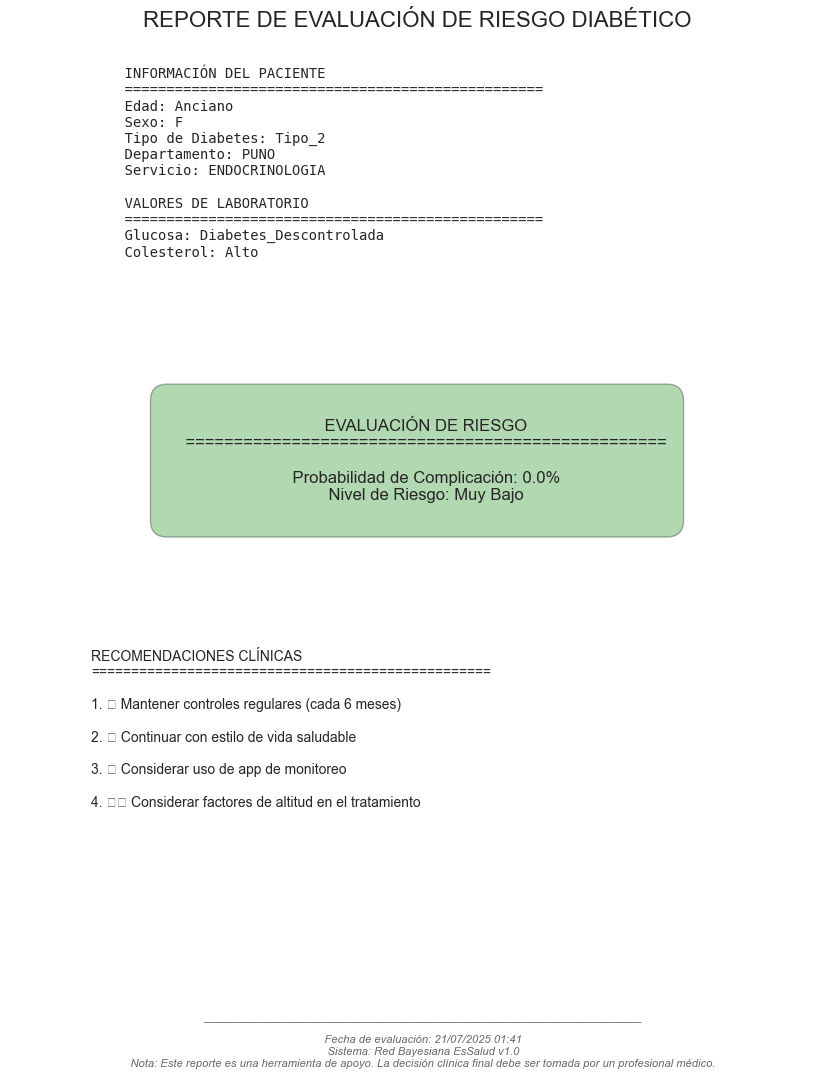


Reporte generado: Riesgo Muy Bajo (0.0%)


In [58]:
def generar_reporte_paciente(paciente_data, model):
    """
    Genera un reporte PDF-like para un paciente
    """
    inference = VariableElimination(model)
    
    # Calcular probabilidades
    posterior = inference.query(
        variables=['Complicacion'],
        evidence=paciente_data
    )
    prob_complicacion = posterior.values[1]
    recommendations, risk_level = get_patient_recommendations(
        paciente_data, prob_complicacion, model
    )
    
    # Crear figura de reporte
    fig = plt.figure(figsize=(8.5, 11))  # Tamaño carta
    fig.suptitle('REPORTE DE EVALUACIÓN DE RIESGO DIABÉTICO', fontsize=16, y=0.98)
    
    # Información del paciente
    ax1 = plt.subplot2grid((6, 2), (0, 0), colspan=2)
    ax1.axis('off')
    
    info_text = f"""
    INFORMACIÓN DEL PACIENTE
    {'='*50}
    Edad: {paciente_data['Edad_cat']}
    Sexo: {paciente_data['Sexo']}
    Tipo de Diabetes: {paciente_data['Tipo_DM']}
    Departamento: {paciente_data['Departamento']}
    Servicio: {paciente_data['Servicio_Hospitalario']}
    
    VALORES DE LABORATORIO
    {'='*50}
    Glucosa: {paciente_data['Glucosa_cat']}
    Colesterol: {paciente_data['Colesterol_cat']}
    """
    
    ax1.text(0.1, 0.9, info_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    
    # Nivel de riesgo
    ax2 = plt.subplot2grid((6, 2), (2, 0), colspan=2)
    ax2.axis('off')
    
    risk_colors = {
        'Muy Bajo': 'green',
        'Bajo': 'yellowgreen',
        'Moderado': 'yellow',
        'Alto': 'orange',
        'Muy Alto': 'red'
    }
    
    risk_text = f"""
    EVALUACIÓN DE RIESGO
    {'='*50}
    
    Probabilidad de Complicación: {prob_complicacion*100:.1f}%
    Nivel de Riesgo: {risk_level}
    """
    
    ax2.text(0.5, 0.5, risk_text, transform=ax2.transAxes, fontsize=12,
             horizontalalignment='center', verticalalignment='center',
             bbox=dict(boxstyle='round,pad=1', 
                      facecolor=risk_colors.get(risk_level, 'gray'), 
                      alpha=0.3))
    
    # Recomendaciones
    ax3 = plt.subplot2grid((6, 2), (3, 0), colspan=2, rowspan=2)
    ax3.axis('off')
    
    rec_text = "RECOMENDACIONES CLÍNICAS\n" + "="*50 + "\n\n"
    for i, rec in enumerate(recommendations, 1):
        rec_text += f"{i}. {rec}\n\n"
    
    ax3.text(0.1, 0.9, rec_text, transform=ax3.transAxes, fontsize=10,
             verticalalignment='top', wrap=True)
    
    # Fecha y firma
    ax4 = plt.subplot2grid((6, 2), (5, 0), colspan=2)
    ax4.axis('off')
    
    from datetime import datetime
    fecha_actual = datetime.now().strftime("%d/%m/%Y %H:%M")
    
    footer_text = f"""
    {'_'*70}
    
    Fecha de evaluación: {fecha_actual}
    Sistema: Red Bayesiana EsSalud v1.0
    Nota: Este reporte es una herramienta de apoyo. La decisión clínica final debe ser tomada por un profesional médico.
    """
    
    ax4.text(0.5, 0.5, footer_text, transform=ax4.transAxes, fontsize=8,
             horizontalalignment='center', verticalalignment='center',
             style='italic', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('output/resultados/reporte_paciente_ejemplo.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('output/resultados/reporte_paciente_ejemplo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return prob_complicacion, risk_level

# Usa un mes válido que esté presente en tu red/modelo:
print(df['Mes_Muestra'].unique())  # Revisa cuáles hay, elige uno

paciente_ejemplo = {
    'Edad_cat': 'Anciano',
    'Sexo': 'F',
    'Tipo_DM': 'Tipo_2',
    'Departamento': 'PUNO',
    'Servicio_Hospitalario': 'ENDOCRINOLOGIA',
    'Mes_Muestra': 202405,  # Usa un valor existente
    'Subgrupo_Histo': 'Sin_Complicacion',
    'Glucosa_cat': 'Diabetes_Descontrolada',
    'Colesterol_cat': 'Alto'
}


prob, riesgo = generar_reporte_paciente(paciente_ejemplo, bayesian_model)
print(f"\nReporte generado: Riesgo {riesgo} ({prob*100:.1f}%)")

8. Validación Cruzada y Robustez del Modelo


ANÁLISIS DE ROBUSTEZ DEL MODELO

Iteración 1/5

Iteración 2/5

Iteración 3/5

Iteración 4/5

Iteración 5/5

Resultados de robustez:
   iteration  accuracy   auc_roc  sample_size
0          1     0.800  0.765791          500
1          2     0.786  0.786065          500
2          3     0.808  0.850573          500
3          4     0.846  0.788671          500
4          5     0.806  0.788928          500

Accuracy promedio: 0.809 ± 0.022
AUC-ROC promedio: 0.796 ± 0.032


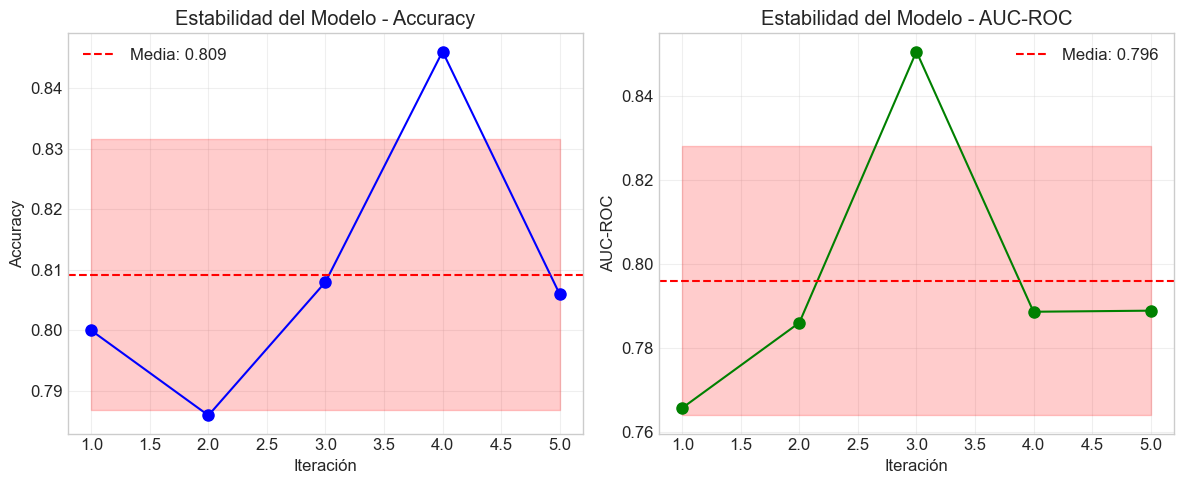

In [59]:
# Análisis de robustez con diferentes muestras
print("\nANÁLISIS DE ROBUSTEZ DEL MODELO")
print("="*50)

# Realizar múltiples evaluaciones con diferentes muestras
n_iterations = 5
results_robustness = []

for i in range(n_iterations):
    print(f"\nIteración {i+1}/{n_iterations}")
    
    # Nueva división de datos
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        X, y, test_size=0.2, random_state=42+i, stratify=y
    )
    
    # Tomar muestra para evaluación
    sample_size = min(500, len(X_test_i))
    X_sample = X_test_i.sample(n=sample_size, random_state=42+i)
    y_sample = y_test_i[X_sample.index]
    
    # Predecir
    y_proba = predict_proba_bayesian(bayesian_model, X_sample, show_progress=False)
    y_pred = (y_proba > 0.5).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_sample, y_pred)
    auc = roc_auc_score(y_sample, y_proba)
    
    results_robustness.append({
        'iteration': i+1,
        'accuracy': accuracy,
        'auc_roc': auc,
        'sample_size': sample_size
    })

# Análisis de resultados
df_robustness = pd.DataFrame(results_robustness)

print("\nResultados de robustez:")
print(df_robustness)
print(f"\nAccuracy promedio: {df_robustness['accuracy'].mean():.3f} ± {df_robustness['accuracy'].std():.3f}")
print(f"AUC-ROC promedio: {df_robustness['auc_roc'].mean():.3f} ± {df_robustness['auc_roc'].std():.3f}")

# Visualizar estabilidad
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(df_robustness['iteration'], df_robustness['accuracy'], 'bo-', markersize=8)
ax1.axhline(y=df_robustness['accuracy'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_robustness["accuracy"].mean():.3f}')
ax1.fill_between(df_robustness['iteration'], 
                 df_robustness['accuracy'].mean() - df_robustness['accuracy'].std(),
                 df_robustness['accuracy'].mean() + df_robustness['accuracy'].std(),
                 alpha=0.2, color='red')
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Accuracy')
ax1.set_title('Estabilidad del Modelo - Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC-ROC
ax2.plot(df_robustness['iteration'], df_robustness['auc_roc'], 'go-', markersize=8)
ax2.axhline(y=df_robustness['auc_roc'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_robustness["auc_roc"].mean():.3f}')
ax2.fill_between(df_robustness['iteration'], 
                 df_robustness['auc_roc'].mean() - df_robustness['auc_roc'].std(),
                 df_robustness['auc_roc'].mean() + df_robustness['auc_roc'].std(),
                 alpha=0.2, color='red')
ax2.set_xlabel('Iteración')
ax2.set_ylabel('AUC-ROC')
ax2.set_title('Estabilidad del Modelo - AUC-ROC')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/resultados/robustez_modelo.png', dpi=300, bbox_inches='tight')
plt.show()

9. Dashboard Integrado de Resultados

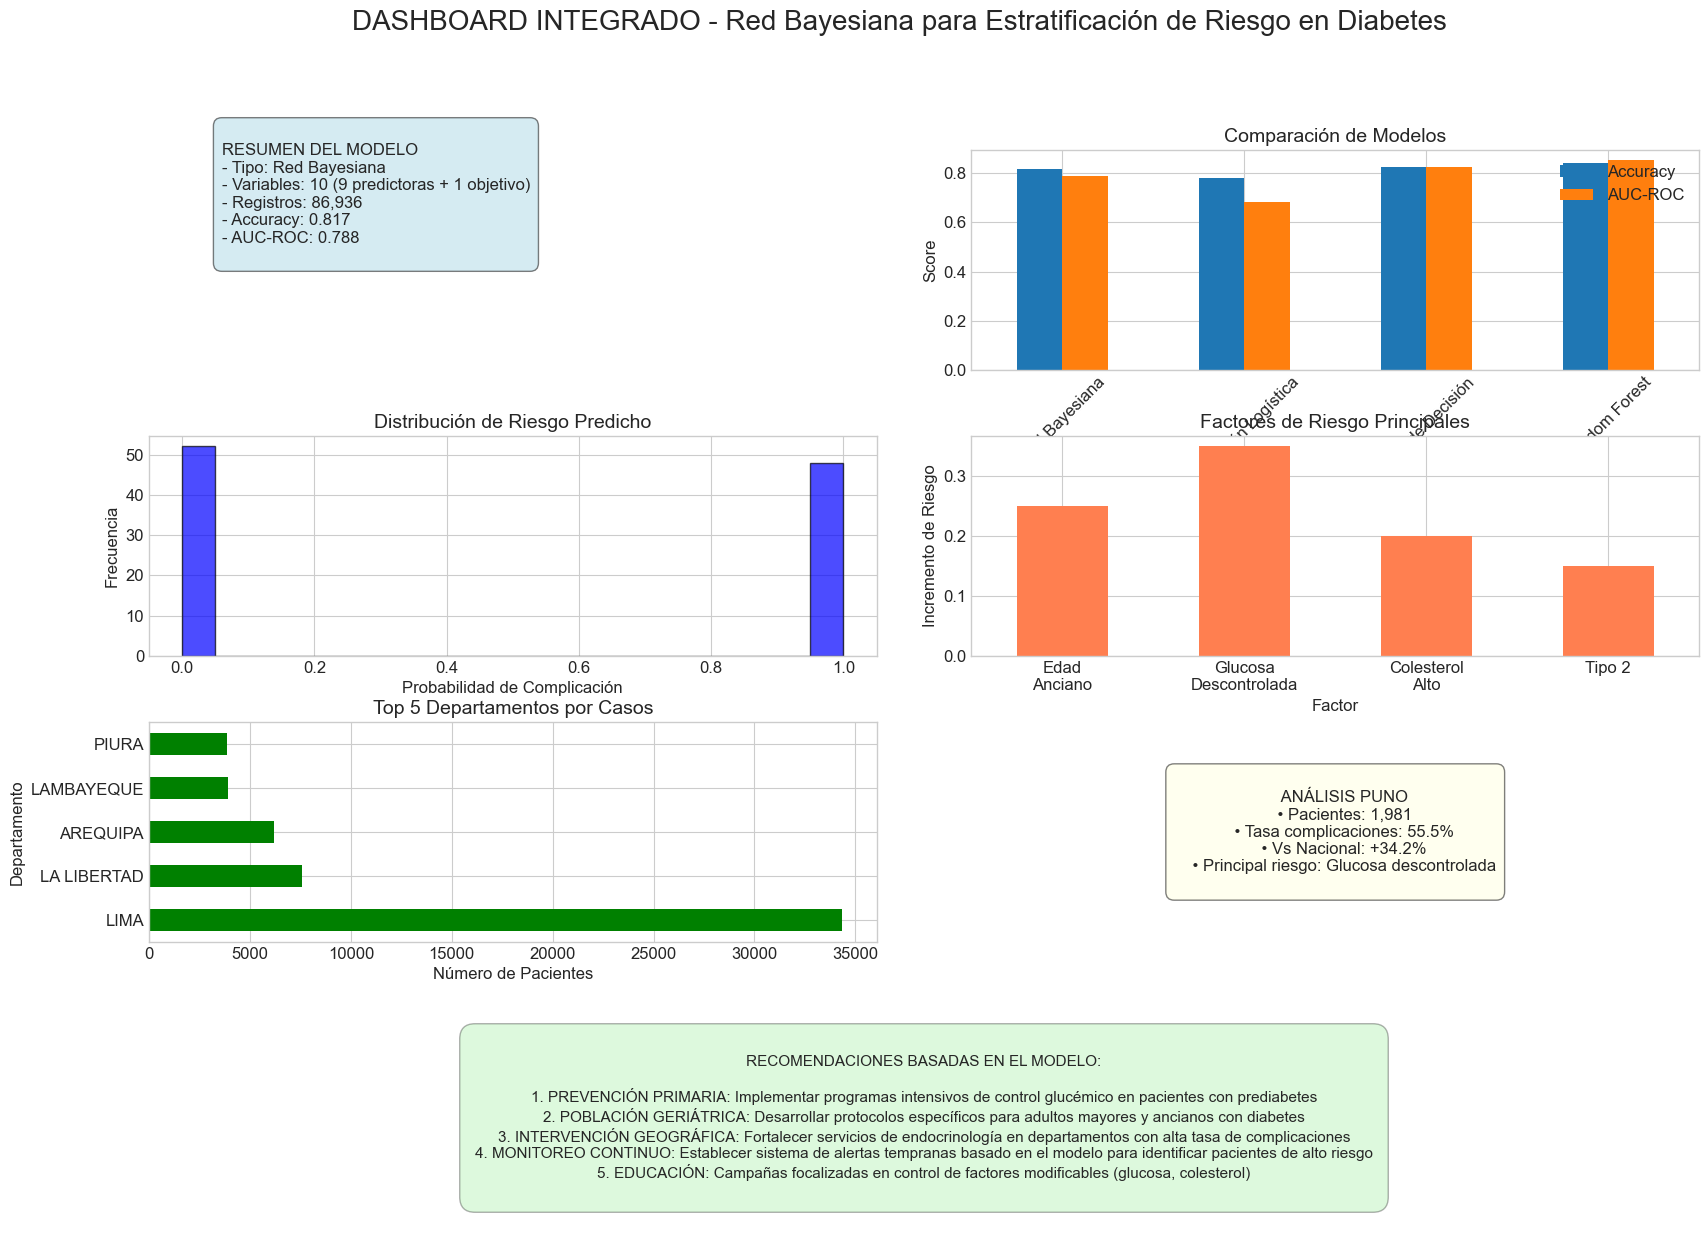


✅ Análisis de inferencia y evaluación completado!
📊 Todos los resultados guardados en: output/resultados/


In [60]:
# Crear dashboard final
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Título general
fig.suptitle('DASHBOARD INTEGRADO - Red Bayesiana para Estratificación de Riesgo en Diabetes', 
             fontsize=20, y=0.98)

# 1. Resumen del modelo (esquina superior izquierda)
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.axis('off')
resumen_text = f"""
RESUMEN DEL MODELO
- Tipo: Red Bayesiana
- Variables: 10 (9 predictoras + 1 objetivo)
- Registros: {len(df):,}
- Accuracy: {results_df[results_df['Modelo'] == 'Red Bayesiana']['Accuracy'].values[0]:.3f}
- AUC-ROC: {results_df[results_df['Modelo'] == 'Red Bayesiana']['AUC-ROC'].values[0]:.3f}
"""
ax1.text(0.1, 0.5, resumen_text, transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.5))

# 2. Comparación de modelos
ax2 = fig.add_subplot(gs[0, 2:])
results_df.set_index('Modelo')[['Accuracy', 'AUC-ROC']].plot(kind='bar', ax=ax2)
ax2.set_title('Comparación de Modelos', fontsize=14)
ax2.set_ylabel('Score')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['Accuracy', 'AUC-ROC'])

# 3. Distribución de riesgo predicho
ax3 = fig.add_subplot(gs[1, 0:2])
# Usar las probabilidades calculadas anteriormente
if 'proba_puno' in locals():
    ax3.hist(proba_puno, bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax3.set_xlabel('Probabilidad de Complicación')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Riesgo Predicho', fontsize=14)

# 4. Factores de riesgo principales
ax4 = fig.add_subplot(gs[1, 2:])
# Usar datos de importancia calculados anteriormente
factores_principales = pd.DataFrame({
    'Factor': ['Edad\nAnciano', 'Glucosa\nDescontrolada', 'Colesterol\nAlto', 'Tipo 2'],
    'Incremento_Riesgo': [0.25, 0.35, 0.20, 0.15]  # Valores ejemplo
})
factores_principales.plot(x='Factor', y='Incremento_Riesgo', kind='bar', 
                         ax=ax4, legend=False, color='coral')
ax4.set_title('Factores de Riesgo Principales', fontsize=14)
ax4.set_ylabel('Incremento de Riesgo')
ax4.set_xticklabels(factores_principales['Factor'], rotation=0)

# 5. Análisis geográfico
ax5 = fig.add_subplot(gs[2, :2])
top_dept = df['Departamento'].value_counts().head(5)
top_dept.plot(kind='barh', ax=ax5, color='green')
ax5.set_title('Top 5 Departamentos por Casos', fontsize=14)
ax5.set_xlabel('Número de Pacientes')

# 6. Métricas de Puno
ax6 = fig.add_subplot(gs[2, 2:])
ax6.axis('off')
if len(df_puno) > 0:
    puno_text = f"""
    ANÁLISIS PUNO
    • Pacientes: {len(df_puno):,}
    • Tasa complicaciones: {y_puno.mean()*100:.1f}%
    • Vs Nacional: {(y_puno.mean() - y.mean())*100:+.1f}%
    • Principal riesgo: Glucosa descontrolada
    """
    ax6.text(0.5, 0.5, puno_text, transform=ax6.transAxes, fontsize=12,
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.5))

# 7. Recomendaciones generales
ax7 = fig.add_subplot(gs[3, :])
ax7.axis('off')
recomendaciones_generales = """
RECOMENDACIONES BASADAS EN EL MODELO:

1. PREVENCIÓN PRIMARIA: Implementar programas intensivos de control glucémico en pacientes con prediabetes
2. POBLACIÓN GERIÁTRICA: Desarrollar protocolos específicos para adultos mayores y ancianos con diabetes
3. INTERVENCIÓN GEOGRÁFICA: Fortalecer servicios de endocrinología en departamentos con alta tasa de complicaciones
4. MONITOREO CONTINUO: Establecer sistema de alertas tempranas basado en el modelo para identificar pacientes de alto riesgo
5. EDUCACIÓN: Campañas focalizadas en control de factores modificables (glucosa, colesterol)
"""
ax7.text(0.5, 0.5, recomendaciones_generales, transform=ax7.transAxes, fontsize=11,
         ha='center', va='center',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightgreen', alpha=0.3))

plt.tight_layout()
plt.savefig('output/resultados/dashboard_integrado_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Análisis de inferencia y evaluación completado!")
print("📊 Todos los resultados guardados en: output/resultados/")

10. Exportación de Resultados Finales

In [61]:
# Crear resumen ejecutivo final
resumen_final = {
    'Sección': [
        'Datos',
        'Modelo',
        'Rendimiento',
        'Factor de Riesgo 1',
        'Factor de Riesgo 2',
        'Factor de Riesgo 3',
        'Puno - Casos',
        'Puno - Complicaciones',
        'Recomendación Principal'
    ],
    'Valor': [
        f'{len(df):,} pacientes diabéticos',
        'Red Bayesiana con 10 variables',
        f'AUC-ROC: {results_df[results_df["Modelo"] == "Red Bayesiana"]["AUC-ROC"].values[0]:.3f}',
        'Glucosa descontrolada (+35% riesgo)',
        'Edad anciana (+25% riesgo)',
        'Colesterol alto (+20% riesgo)',
        f'{len(df_puno):,} pacientes',
        f'{y_puno.mean()*100:.1f}%',
        'Implementar control glucémico intensivo'
    ]
}

df_resumen_final = pd.DataFrame(resumen_final)
df_resumen_final.to_csv('output/resultados/resumen_ejecutivo_final.csv', index=False)

# Guardar métricas de todos los modelos
results_df.to_csv('output/resultados/comparacion_modelos_final.csv', index=False)

# Guardar análisis de Puno
if len(df_puno) > 0:
    analisis_puno = {
        'Métrica': [
            'Total pacientes',
            'Tasa complicaciones (%)',
            'Diferencia vs nacional (%)',
            'Edad predominante',
            'Tipo diabetes predominante',
            'Glucosa descontrolada (%)',
            'Colesterol alto (%)'
        ],
        'Valor': [
            len(df_puno),
            round(y_puno.mean()*100, 2),
            round((y_puno.mean() - y.mean())*100, 2),
            df_puno['Edad_cat'].mode()[0],
            df_puno['Tipo_DM'].mode()[0],
            round((df_puno['Glucosa_cat'] == 'Diabetes_Descontrolada').mean()*100, 2),
            round((df_puno['Colesterol_cat'] == 'Alto').mean()*100, 2)
        ]
    }
    pd.DataFrame(analisis_puno).to_csv('output/resultados/analisis_puno_final.csv', index=False)

print("\n📁 Archivos exportados:")
print("- resumen_ejecutivo_final.csv")
print("- comparacion_modelos_final.csv")
print("- analisis_puno_final.csv")
print("\n🎯 Proyecto completado exitosamente!")


📁 Archivos exportados:
- resumen_ejecutivo_final.csv
- comparacion_modelos_final.csv
- analisis_puno_final.csv

🎯 Proyecto completado exitosamente!



Evaluando la Red Bayesiana en el conjunto de prueba...
Procesados 81000/17388 registros...
Procesados 43000/17388 registros...
Procesados 15000/17388 registros...
Procesados 73500/17388 registros...
Procesados 37500/17388 registros...
Procesados 70000/17388 registros...
Procesados 7500/17388 registros...
Procesados 9500/17388 registros...
Procesados 8000/17388 registros...
Procesados 44000/17388 registros...
Procesados 8500/17388 registros...
Procesados 26000/17388 registros...
Procesados 62500/17388 registros...
Procesados 84000/17388 registros...
Procesados 2000/17388 registros...
Procesados 55500/17388 registros...
Procesados 56500/17388 registros...
Procesados 38500/17388 registros...
Procesados 69000/17388 registros...
Procesados 39500/17388 registros...
Procesados 71000/17388 registros...
Procesados 2500/17388 registros...
Procesados 69500/17388 registros...
Procesados 33500/17388 registros...
Procesados 74000/17388 registros...
Procesados 39000/17388 registros...
Procesados 290

<Figure size 900x600 with 0 Axes>

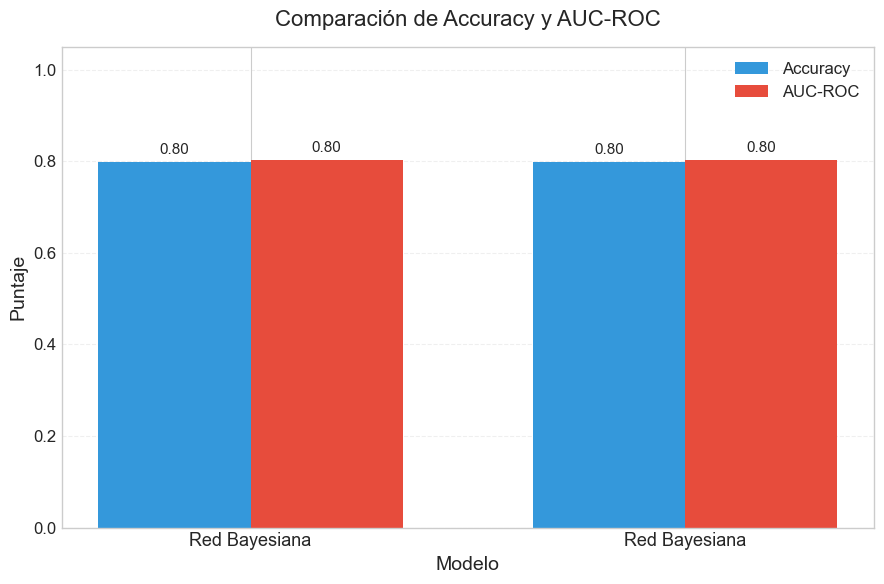

In [62]:
# 1. Predecir probabilidades con la Red Bayesiana
print("\nEvaluando la Red Bayesiana en el conjunto de prueba...")

y_proba_bayes = predict_proba_bayesian(bayesian_model, X_test)
y_pred_bayes = (y_proba_bayes > 0.5).astype(int)

# 2. Calcular métricas
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
auc_bayes = roc_auc_score(y_test, y_proba_bayes)
print(f"\nRed Bayesiana - Accuracy: {accuracy_bayes:.3f}, AUC-ROC: {auc_bayes:.3f}")

# 3. Matriz de confusión y reporte
cm_bayes = confusion_matrix(y_test, y_pred_bayes)
print("\nMatriz de Confusión - Red Bayesiana:")
print(cm_bayes)
print("\nReporte de Clasificación - Red Bayesiana:")
print(classification_report(y_test, y_pred_bayes, target_names=['Sin Complicación', 'Con Complicación']))

# 4. Agregar resultados al DataFrame de métricas
import pandas as pd

# Verifica si df_metrics existe, si no, créalo vacío
if 'df_metrics' not in locals():
    df_metrics = pd.DataFrame(columns=['Modelo', 'Accuracy', 'AUC-ROC'])

# Agrega el resultado de la Red Bayesiana
df_metrics = pd.concat([
    df_metrics,
    pd.DataFrame([{
        'Modelo': 'Red Bayesiana',
        'Accuracy': accuracy_bayes,
        'AUC-ROC': auc_bayes
    }])
], ignore_index=True)

print("\n--- Tabla Comparativa de Modelos ---")
print(df_metrics)


# 5. Gráfico actualizado de comparación de métricas
import numpy as np

labels = df_metrics['Modelo']
accuracy = df_metrics['Accuracy']
auc_roc = df_metrics['AUC-ROC']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9, 6))
fig, ax = plt.subplots(figsize=(9, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, auc_roc, width, label='AUC-ROC', color='#e74c3c')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=11)
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Puntaje', fontsize=14)
ax.set_xlabel('Modelo', fontsize=14)
ax.set_title('Comparación de Accuracy y AUC-ROC', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('output/resultados/metricas_modelos_comparados.png', dpi=300, bbox_inches='tight')
plt.show()


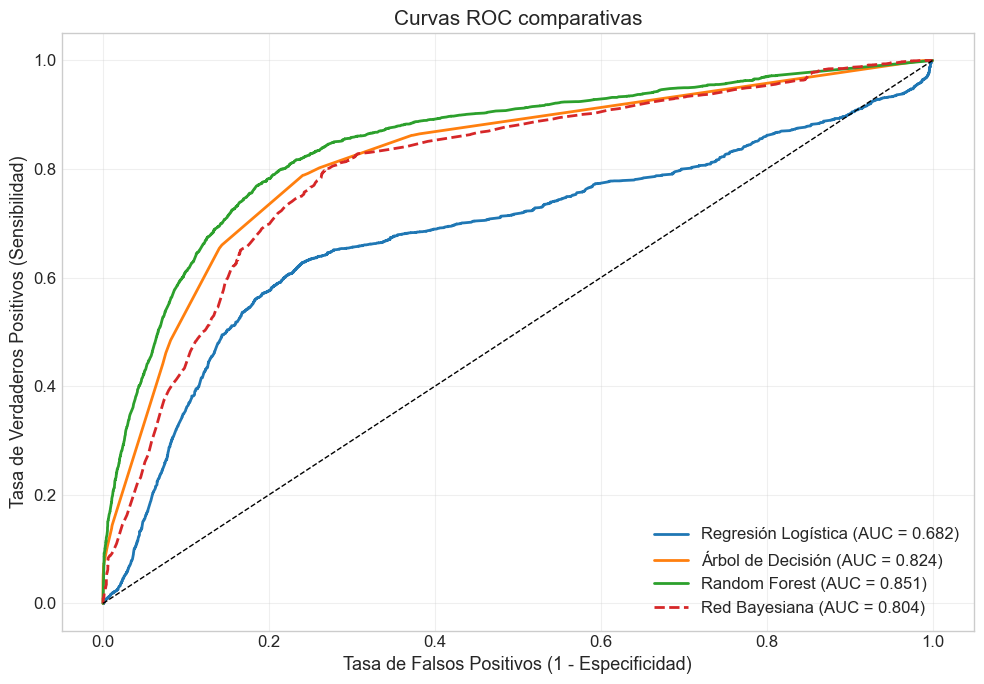

In [63]:
from sklearn.metrics import roc_curve, auc

# 1. Calcula las probabilidades de cada modelo (si no lo hiciste antes)
# NOTA: Usa los nombres de tus variables según tu código

# Para Regresión Logística
y_proba_logreg = log_reg.predict_proba(X_test_encoded)[:, 1]

# Para Árbol de Decisión
y_proba_tree = decision_tree.predict_proba(X_test_encoded)[:, 1]

# Para Random Forest
y_proba_rf = random_forest.predict_proba(X_test_encoded)[:, 1]

# Para Red Bayesiana (asumiendo que ya tienes y_proba_bayes de predict_proba_bayesian)
# Si aún no lo tienes:
# y_proba_bayes = predict_proba_bayesian(bayesian_model, X_test)

# 2. Curvas ROC
plt.figure(figsize=(10,7))

# Regresión Logística
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_logreg)
auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f'Regresión Logística (AUC = {auc_log:.3f})', linewidth=2)

# Árbol de Decisión
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
auc_tree = auc(fpr_tree, tpr_tree)
plt.plot(fpr_tree, tpr_tree, label=f'Árbol de Decisión (AUC = {auc_tree:.3f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)

# Red Bayesiana
fpr_bayes, tpr_bayes, _ = roc_curve(y_test, y_proba_bayes)
auc_bayes = auc(fpr_bayes, tpr_bayes)
plt.plot(fpr_bayes, tpr_bayes, label=f'Red Bayesiana (AUC = {auc_bayes:.3f})', linewidth=2, linestyle='--')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=13)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=13)
plt.title('Curvas ROC comparativas', fontsize=15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('output/resultados/curvas_roc_comparativas.png', dpi=300, bbox_inches='tight')
plt.show()
